### 1. Importing Libraires

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import joblib
import os
import pickle
df = pd.read_csv("../data/processed/matches_processed.csv")

In [2]:
df

,Division,MatchDate,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,Form5Away,...,BookieBiasAway,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Day_sin,Day_cos,EloOddsGap,FormVolatility,OddSkew
0,SP1,2000-09-09,Barcelona,Malaga,1888.11,1737.16,0.0,0.0,0.0,0.0,...,0.126582,-0.974928,-0.222521,-1.0,-1.836970e-16,0.968077,-0.250653,0.133849,0.0,-0.721133
1,SP1,2000-09-09,La Coruna,Ath Bilbao,1845.68,1779.40,0.0,0.0,0.0,0.0,...,0.161290,-0.974928,-0.222521,-1.0,-1.836970e-16,0.968077,-0.250653,-0.008181,0.0,-0.608301
2,SP1,2000-09-09,Real Madrid,Valencia,1884.76,1907.14,0.0,0.0,0.0,0.0,...,0.243902,-0.974928,-0.222521,-1.0,-1.836970e-16,0.968077,-0.250653,-0.134891,0.0,-0.426087
3,SP1,2000-09-09,Sociedad,Santander,1778.08,1755.62,0.0,0.0,0.0,0.0,...,0.289855,-0.974928,-0.222521,-1.0,-1.836970e-16,0.968077,-0.250653,-0.252493,0.0,-0.301887
4,SP1,2000-09-09,Zaragoza,Espanol,1848.53,1786.64,0.0,0.0,0.0,0.0,...,0.232558,-0.974928,-0.222521,-1.0,-1.836970e-16,0.968077,-0.250653,-0.152836,0.0,-0.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,SP1,2025-05-24,Getafe,Celta,1634.54,1694.08,3.0,3.0,6.0,9.0,...,0.315412,-0.974928,-0.222521,0.5,-8.660254e-01,-0.988468,0.151428,-0.791724,-3.0,0.388158
9004,SP1,2025-05-24,Vallecano,Mallorca,1651.11,1652.13,7.0,10.0,3.0,3.0,...,-0.178535,-0.974928,-0.222521,0.5,-8.660254e-01,-0.988468,0.151428,-0.001050,3.0,-0.617021
9005,SP1,2025-05-25,Girona,Ath Madrid,1655.05,1856.09,3.0,7.0,6.0,10.0,...,0.123932,-0.781831,0.623490,0.5,-8.660254e-01,-0.937752,0.347305,-0.714650,0.0,0.310954
9006,SP1,2025-05-25,Villarreal,Sevilla,1769.85,1648.82,9.0,15.0,3.0,4.0,...,-0.059621,-0.781831,0.623490,0.5,-8.660254e-01,-0.937752,0.347305,0.004629,5.0,-0.616294


In [3]:
# Filter matches after August 2010
df = df[df['MatchDate'] > '2010-08']

In [4]:
# Drop teams with less than 20 games 
counts_home = df['HomeTeam'].value_counts()
counts_away = df['AwayTeam'].value_counts()

valid_teams = counts_home[counts_home >= 20].index.intersection(counts_away[counts_away >= 20].index)
df = df[(df['HomeTeam'].isin(valid_teams)) & (df['AwayTeam'].isin(valid_teams))]

### 2. Separating into X and y

In [5]:
X = df[['MatchDate', 'HomeTeam', 'AwayTeam', 'Year',  'IsWeekend',
         'C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB',
        'HomeElo', 'AwayElo', 'EloDifference', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'Form3Difference', 'Form5Difference',
        'GF3Home', 'GF3Away', 'GA3Home', 'GA3Away', 'GF5Home', 'GF5Away', 'GA5Home', 'GA5Away',
        'OddHome', 'OddDraw', 'OddAway', 'ImpliedProbHome', 'ImpliedProbDraw', 'ImpliedProbAway', 'BookmakerMargin',
        'HandiSize', 'HandiHome', 'HandiAway', 
        'MaxHome', 'MaxDraw', 'MaxAway', 'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 
        'WinStreakHome', 'WinStreakAway', 'DrawStreakHome', 'DrawStreakAway', 'DefeatStreakHome', 'DefeatStreakAway', 'H2HHomeWins', 'H2HAwayWins', 'GF_EMA3_Home','GF_EMA3_Away', 'GF3HomeSTD',
        'GF3AwaySTD', 'Season', 'PointsAcumHome', 'PointsAcumAway', 
        'GF_Total_Home', 'GF_Total_Away', 'GA_Total_Home', 'GA_Total_Away', 
        'GD_total_Home', 'GD_total_Away', 'PointMeanHome', 'PointMeanAway', 'ScoredGoalsMeanHome', 'ScoredGoalsMeanAway', 'ConcededGoalsMeanHome', 'ConcededGoalsMeanAway',
        'GoalsDifferenceMeanHome','GoalsDifferenceMeanAway','WinHomeAcum','WinAwayAcum','DrawHomeAcum','DrawAwayAcum','LossHomeAcum', 'LossAwayAcum', 'WinRateHome','WinRateAway','DrawRateHome',
        'DrawRateAway','LossRateHome','LossRateAway', 
        "OddsDifference", "EloRatio", "FormRatio", "GoalRateRatio", "WinRateDiff", "PointsDiff", "FormDiff", "Elo_ProbDiff", "FormOddsDiff", "StreakDiff", "BookieBiasHome", "DayOfWeek_sin", "DayOfWeek_cos", "Month_sin", "Month_cos", "Day_sin", "Day_cos",
        'OddSkew', 'FormVolatility', 'EloOddsGap', 'ImpliedProbTotal', 'BookieBiasAway'
]]
y = df['Results']

### 2.1 Separating into X and y without draw

In [6]:
cols_draw = ['DrawStreakHome', 'DrawStreakAway', 
             'DrawHomeAcum', 'DrawAwayAcum',
             'DrawRateHome', 'DrawRateAway',
             'OddDraw', 'ImpliedProbDraw', 'MaxDraw']
# Dropping Draws
not_draw= y != 1
X_not_draw = X[not_draw].copy()
X_not_draw = X_not_draw.drop(columns=cols_draw)
y_not_draw = y[not_draw].copy()

### 3. Separating into Train and Test. Dividing it before 2021/2022 season and after 2022/2023 season

In [7]:
X_train = X[X['MatchDate'] < '2021-07'].drop(columns='MatchDate')
X_test = X[X['MatchDate'] > '2021-08'].drop(columns='MatchDate')
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]



# X and y without draw
X_train_nd = X_not_draw[X_not_draw['MatchDate'] < '2021-07'].drop(columns='MatchDate')
X_test_nd = X_not_draw[X_not_draw['MatchDate'] > '2021-08'].drop(columns='MatchDate')
y_train_nd = y_not_draw.loc[X_train_nd.index]
y_test_nd = y_not_draw.loc[X_test_nd.index]

### 5. Model Training

In [8]:
# Categorical colums
cat_cols = ['HomeTeam', 'AwayTeam']



# Numerical Colums
num_cols= ['Year',  'IsWeekend',
         'C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB',
        'HomeElo', 'AwayElo', 'EloDifference', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'Form3Difference', 'Form5Difference',
        'GF3Home', 'GF3Away', 'GA3Home', 'GA3Away', 'GF5Home', 'GF5Away', 'GA5Home', 'GA5Away',
        'OddHome', 'OddDraw', 'OddAway', 'ImpliedProbHome', 'ImpliedProbDraw', 'ImpliedProbAway', 'BookmakerMargin',
        'HandiSize', 'HandiHome', 'HandiAway', 
        'MaxHome', 'MaxDraw', 'MaxAway', 'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 
        'WinStreakHome', 'WinStreakAway', 'DrawStreakHome', 'DrawStreakAway', 'DefeatStreakHome', 'DefeatStreakAway', 'H2HHomeWins', 'H2HAwayWins', 'GF_EMA3_Home','GF_EMA3_Away', 'GF3HomeSTD',
        'GF3AwaySTD', 'Season', 'PointsAcumHome', 'PointsAcumAway', 
        'GF_Total_Home', 'GF_Total_Away', 'GA_Total_Home', 'GA_Total_Away', 
        'GD_total_Home', 'GD_total_Away', 'PointMeanHome', 'PointMeanAway', 'ScoredGoalsMeanHome', 'ScoredGoalsMeanAway', 'ConcededGoalsMeanHome', 'ConcededGoalsMeanAway',
        'GoalsDifferenceMeanHome','GoalsDifferenceMeanAway','WinHomeAcum','WinAwayAcum','DrawHomeAcum','DrawAwayAcum','LossHomeAcum', 'LossAwayAcum', 'WinRateHome','WinRateAway','DrawRateHome',
        'DrawRateAway','LossRateHome','LossRateAway', 
        "OddsDifference", "EloRatio", "FormRatio", "GoalRateRatio", "WinRateDiff", "PointsDiff", "FormDiff", "Elo_ProbDiff", "FormOddsDiff", "StreakDiff", "BookieBiasHome", "DayOfWeek_sin", "DayOfWeek_cos", "Month_sin", "Month_cos", "Day_sin", "Day_cos",
        'OddSkew', 'FormVolatility', 'EloOddsGap']

# Numerical Colums without draw
num_cols_nd= ['Year',  'IsWeekend',
         'C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB',
        'HomeElo', 'AwayElo', 'EloDifference', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'Form3Difference', 'Form5Difference',
        'GF3Home', 'GF3Away', 'GA3Home', 'GA3Away', 'GF5Home', 'GF5Away', 'GA5Home', 'GA5Away',
        'OddHome', 'OddAway', 'ImpliedProbHome', 'ImpliedProbAway', 'BookmakerMargin',
        'HandiSize', 'HandiHome', 'HandiAway', 
        'MaxHome', 'MaxAway', 'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 
        'WinStreakHome', 'WinStreakAway', 'DefeatStreakHome', 'DefeatStreakAway', 'H2HHomeWins', 'H2HAwayWins', 'GF_EMA3_Home','GF_EMA3_Away', 'GF3HomeSTD',
        'GF3AwaySTD', 'Season', 'PointsAcumHome', 'PointsAcumAway', 
        'GF_Total_Home', 'GF_Total_Away', 'GA_Total_Home', 'GA_Total_Away', 
        'GD_total_Home', 'GD_total_Away', 'PointMeanHome', 'PointMeanAway', 'ScoredGoalsMeanHome', 'ScoredGoalsMeanAway', 'ConcededGoalsMeanHome', 'ConcededGoalsMeanAway',
        'GoalsDifferenceMeanHome','GoalsDifferenceMeanAway','WinHomeAcum','WinAwayAcum','LossHomeAcum', 'LossAwayAcum', 'WinRateHome','WinRateAway',
        'LossRateHome','LossRateAway', 
        "OddsDifference", "EloRatio", "FormRatio", "GoalRateRatio", "WinRateDiff", "PointsDiff", "FormDiff", "Elo_ProbDiff", "FormOddsDiff", "StreakDiff", "BookieBiasHome", "DayOfWeek_sin", "DayOfWeek_cos", "Month_sin", "Month_cos", "Day_sin", "Day_cos",
        'OddSkew', 'FormVolatility', 'EloOddsGap']

### Preprocessing Pipelines

#### 1. Numerical Pipeline
- This pipeline applies StandardScaler to the numerical columns (num_cols or num_cols_nd), scaling them to have a mean of 0 and standard deviation of 1. This ensures that all numerical features are on the same scale, which is important for many machine learning algorithms.

In [9]:
num_pipe = Pipeline(steps=[ 
    ('scaler', StandardScaler())
    ])

#### 2. Categorical Pipeline
**`OneHot`**: This pipeline converts categorical columns into one-hot encoded vectors. Each unique category becomes a binary column.

- handle_unknown='ignore' ensures the transformer won't break if a new category appears in test data.

- sparse_output=False returns a dense array instead of a sparse matrix.

**`Ordinal`**: This pipeline converts categorical variables into integer codes.

- Each category is assigned a unique integer.

- Unknown categories are encoded as -1.

In [10]:
# Categorical pipe with OneHot
cat_pipe_onehot = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Categorical pipe with Ordinal
cat_pipe_ordinal = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


#### 3. ColumnTransformer 
**`OneHot`**: This applies the appropriate preprocessing to numerical and categorical columns for datasets including draws (onehot_transformer) or excluding draws (onehot_transformer_nd).

- remainder='passthrough' keeps any columns not explicitly listed.

- n_jobs=-1 allows parallel processing.


**`Ordinal`**: Similar to the OneHot transformers, but uses ordinal encoding for categorical columns. These transformers are useful when models can handle integer-encoded categories directly.

- ordinal_transformer → for datasets including draws.

- ordinal_transformer_nd → for datasets excluding draws.


In [11]:
onehot_transformer = ColumnTransformer(transformers= [
    ('num_pipeline', num_pipe, num_cols),
    ('cat_pipeline', cat_pipe_onehot, cat_cols)], 
    remainder= 'passthrough',
    n_jobs= -1)

onehot_transformer_nd = ColumnTransformer(transformers= [
    ('num_pipeline', num_pipe, num_cols_nd),
    ('cat_pipeline', cat_pipe_onehot, cat_cols)], 
    remainder= 'passthrough',
    n_jobs= -1)


ordinal_transformer = ColumnTransformer(transformers= [
    ('num_pipeline', num_pipe, num_cols),
    ('cat_pipeline', cat_pipe_ordinal, cat_cols)], 
    remainder= 'passthrough',
    n_jobs= -1)

ordinal_transformer_nd = ColumnTransformer(transformers= [
    ('num_pipeline', num_pipe, num_cols_nd),
    ('cat_pipeline', cat_pipe_ordinal, cat_cols)], 
    remainder= 'passthrough',
    n_jobs= -1)


### **Logistic Reegression**
We define two pipelines for Logistic Regression:

1. **Pipeline including draw results** (`pipe_LR`)
2. **Pipeline excluding draw results** (`pipe_LR_nd`)

Both pipelines follow a similar structure:

In [12]:
pipe_LR = Pipeline(steps=[
            ('preprocessor', onehot_transformer),
            ('smote', SMOTE(random_state=42)),
            ('classifier', LogisticRegression(max_iter=1000, solver='liblinear', random_state=42))])

logistic_params = {
        'preprocessor': [onehot_transformer, ordinal_transformer],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__class_weight': [None, 'balanced']}

logistic_RS = RandomizedSearchCV(estimator = pipe_LR,
                        param_distributions=  logistic_params,
                        cv = 5,
                        verbose=2,
                        n_jobs=-1, 
                        scoring= 'accuracy',
                        random_state=42)

print("LR with Draw: ")
logistic_RS.fit(X_train, y_train)
y_pred_logistic = logistic_RS.predict(X_test)
print(classification_report(y_test, y_pred_logistic))


LR with Draw: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.52      0.53      0.53       433
           1       0.33      0.44      0.38       404
           2       0.68      0.54      0.60       683

    accuracy                           0.51      1520
   macro avg       0.51      0.50      0.50      1520
weighted avg       0.54      0.51      0.52      1520



In [13]:
pipe_LR_nd = Pipeline(steps=[
            ('preprocessor', onehot_transformer_nd),
            ('smote', SMOTE(random_state=42)),
            ('classifier', LogisticRegression(max_iter=1000, solver='liblinear', random_state=42))])

logistic_params_nd = {
        'preprocessor': [onehot_transformer_nd, ordinal_transformer_nd],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__class_weight': [None, 'balanced']}

logistic_RS_nd = RandomizedSearchCV(estimator = pipe_LR_nd,
                        param_distributions=  logistic_params_nd,
                        cv = 5,
                        verbose=2,
                        n_jobs=-1, 
                        scoring= 'accuracy',
                        random_state=42)
print("LR without Draw: ")
logistic_RS_nd.fit(X_train_nd, y_train_nd)
y_pred_logistic_nd = logistic_RS_nd.predict(X_test_nd)
print(classification_report(y_test_nd, y_pred_logistic_nd))

LR without Draw: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.58      0.76      0.66       433
           2       0.81      0.65      0.73       683

    accuracy                           0.70      1116
   macro avg       0.70      0.71      0.69      1116
weighted avg       0.72      0.70      0.70      1116



### **Random Forest**
We define two pipelines for Logistic Regression:

1. **Pipeline including draw results** (`pipe_rf`)
2. **Pipeline excluding draw results** (`pipe_rf_nd`)

Both pipelines follow a similar structure:

In [14]:
pipe_rf = Pipeline(steps=[
        ('preprocessor', onehot_transformer),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))])

random_forest_params = {
    'preprocessor__num_pipeline__scaler': [StandardScaler(), MinMaxScaler(), None],
    'preprocessor': [onehot_transformer, ordinal_transformer],
    "classifier__n_estimators": [200, 300, 500, 1000],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    "classifier__max_depth": [3, 5, 7, 15]}

random_forest_RS = RandomizedSearchCV(estimator = pipe_rf,
                    param_distributions=  random_forest_params,
                    cv = 5,
                    verbose=2,
                    n_jobs=-1, 
                    scoring= 'accuracy',
                    random_state=42)

print("RF with Draw: ")
random_forest_RS.fit(X_train, y_train)
y_pred_rf = random_forest_RS.predict(X_test)
print(classification_report(y_test, y_pred_rf))


RF with Draw: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.57      0.42      0.48       433
           1       0.33      0.51      0.40       404
           2       0.67      0.56      0.61       683

    accuracy                           0.51      1520
   macro avg       0.52      0.49      0.50      1520
weighted avg       0.55      0.51      0.52      1520



In [15]:
pipe_rf_nd = Pipeline(steps=[
        ('preprocessor', onehot_transformer_nd),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))])

random_forest_params_nd = {
    'preprocessor__num_pipeline__scaler': [StandardScaler(), MinMaxScaler(), None],
    'preprocessor': [onehot_transformer_nd, ordinal_transformer_nd],
    "classifier__n_estimators": [200, 300, 500, 1000],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    "classifier__max_depth": [3, 5, 7, 15]}

random_forest_RS_nd = RandomizedSearchCV(estimator = pipe_rf_nd,
                    param_distributions=  random_forest_params_nd,
                    cv = 5,
                    verbose=2,
                    n_jobs=-1, 
                    scoring= 'accuracy',
                    random_state=42)

print("RF without Draw: ")
random_forest_RS_nd.fit(X_train_nd, y_train_nd)
y_pred_rf_nd = random_forest_RS_nd.predict(X_test_nd)
print(classification_report(y_test_nd, y_pred_rf_nd))

RF without Draw: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.65      0.62      0.64       433
           2       0.77      0.79      0.78       683

    accuracy                           0.72      1116
   macro avg       0.71      0.71      0.71      1116
weighted avg       0.72      0.72      0.72      1116



### **XGBOOST**
We define two pipelines for Logistic Regression:

1. **Pipeline including draw results** (`pipe_xgb`)
2. **Pipeline excluding draw results** (`pipe_xgb_nd`)

Both pipelines follow a similar structure:

In [16]:
pipe_xgb = Pipeline(steps=[
        ('preprocessor', onehot_transformer),
        ('smote', SMOTE(random_state=42)),
        ('classifier', XGBClassifier(random_state=42))])
xgb_params = {
    'preprocessor': [onehot_transformer, ordinal_transformer],
    "classifier__n_estimators": [200, 500],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.01, 0.05, 0.1],
    "classifier__subsample": [0.8, 1],
    "classifier__colsample_bytree": [0.8, 1]
}

xgb_RS = RandomizedSearchCV(estimator = pipe_xgb,
                    param_distributions=  xgb_params,
                    cv = 5,
                    verbose=2,
                    n_jobs=-1, 
                    scoring= 'f1_macro',
                    random_state=42)

print("XGB with Draw: ")
xgb_RS.fit(X_train, y_train)
y_pred_xgb = xgb_RS.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

XGB with Draw: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.49      0.54      0.51       433
           1       0.35      0.30      0.33       404
           2       0.61      0.62      0.62       683

    accuracy                           0.51      1520
   macro avg       0.48      0.49      0.49      1520
weighted avg       0.51      0.51      0.51      1520



In [17]:

pipe_xgb_nd = Pipeline(steps=[
        ('preprocessor', onehot_transformer_nd),
        ('smote', SMOTE(random_state=42)),
        ('classifier', XGBClassifier(random_state=42))])

xgb_params_nd = {
    'preprocessor': [onehot_transformer_nd, ordinal_transformer_nd],
    "classifier__n_estimators": [200, 500],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.01, 0.05, 0.1],
    "classifier__subsample": [0.8, 1],
    "classifier__colsample_bytree": [0.8, 1]}

xgb_RS_nd = RandomizedSearchCV(estimator = pipe_xgb_nd,
                    param_distributions=  xgb_params_nd,
                    cv = 5,
                    verbose=2,
                    n_jobs=-1, 
                    scoring= 'accuracy',
                    random_state=42)


y_train_xgb = y_train_nd.map({0: 0, 2: 1})
y_test_xgb = y_test_nd.map({0: 0, 2: 1})

print("XGB without Draw: ")
xgb_RS_nd.fit(X_train_nd, y_train_xgb)
y_pred_xgb_nd = xgb_RS_nd.predict(X_test_nd)
print(classification_report(y_test_xgb, y_pred_xgb_nd))

XGB without Draw: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.62      0.59      0.60       433
           1       0.75      0.77      0.76       683

    accuracy                           0.70      1116
   macro avg       0.68      0.68      0.68      1116
weighted avg       0.70      0.70      0.70      1116



### **KNN**
We define two pipelines for Logistic Regression:

1. **Pipeline including draw results** (`pipe_knn`)
2. **Pipeline excluding draw results** (`pipe_knn_nd`)

Both pipelines follow a similar structure:

In [18]:
pipe_knn = Pipeline(steps=[
        ('preprocessor', onehot_transformer),
        ('smote', SMOTE(random_state=42)),
        ('classifier', KNeighborsClassifier())])

knn_params = {
    'preprocessor': [onehot_transformer, ordinal_transformer],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]  }

knn_RS = RandomizedSearchCV(estimator = pipe_knn,
                    param_distributions=  knn_params,
                    cv = 5,
                    verbose=2,
                    n_jobs=-1, 
                    scoring= 'accuracy',
                    random_state=42)

print("KNN with Draw: ")
knn_RS.fit(X_train, y_train)
y_pred_knn = knn_RS.predict(X_test)
print(classification_report(y_test, y_pred_knn))

KNN with Draw: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.37      0.51      0.43       433
           1       0.28      0.42      0.34       404
           2       0.69      0.34      0.45       683

    accuracy                           0.41      1520
   macro avg       0.45      0.42      0.41      1520
weighted avg       0.49      0.41      0.41      1520



In [19]:
pipe_knn_nd = Pipeline(steps=[
        ('preprocessor', onehot_transformer_nd),
        ('smote', SMOTE(random_state=42)),
        ('classifier', KNeighborsClassifier())
        ])

knn_params_nd = {
    'preprocessor': [onehot_transformer_nd, ordinal_transformer_nd],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]  
}

knn_RS_nd = RandomizedSearchCV(estimator = pipe_knn_nd,
                    param_distributions=  knn_params_nd,
                    cv = 5,
                    verbose=2,
                    n_jobs=-1, 
                    scoring= 'accuracy',
                    random_state=42)


print("KNN without Draw: ")
knn_RS_nd.fit(X_train_nd, y_train_nd)
y_pred_knn_nd = knn_RS_nd.predict(X_test_nd)
print(classification_report(y_test_nd, y_pred_knn_nd))

KNN without Draw: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.54      0.76      0.63       433
           2       0.80      0.59      0.68       683

    accuracy                           0.66      1116
   macro avg       0.67      0.68      0.66      1116
weighted avg       0.70      0.66      0.66      1116



### **Gradient Boosting**
We define two pipelines for Logistic Regression:

1. **Pipeline including draw results** (`pipe_gbm`)
2. **Pipeline excluding draw results** (`pipe_gbm_nd`)

Both pipelines follow a similar structure:

In [20]:
pipe_gbm = Pipeline(steps=[
        ('preprocessor', onehot_transformer),
        ('smote', SMOTE(random_state=42)),
        ('classifier', GradientBoostingClassifier(random_state=42))
        ])

gbm_params = {
    'preprocessor': [onehot_transformer, ordinal_transformer],
    'classifier__n_estimators': [100, 200, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]}

gbm_RS = RandomizedSearchCV(estimator = pipe_gbm,
                    param_distributions=  gbm_params,
                    cv = 5,
                    verbose=2,
                    n_jobs=-1, 
                    scoring= 'accuracy',
                    random_state=42)


print("GBM with Draw: ")
gbm_RS.fit(X_train, y_train)
y_pred_gbm = gbm_RS.predict(X_test)
print(classification_report(y_test, y_pred_gbm))

GBM with Draw: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.49      0.48      0.48       433
           1       0.34      0.31      0.33       404
           2       0.60      0.65      0.62       683

    accuracy                           0.51      1520
   macro avg       0.48      0.48      0.48      1520
weighted avg       0.50      0.51      0.50      1520



In [21]:

pipe_gbm_nd = Pipeline(steps=[
        ('preprocessor', onehot_transformer_nd),
        ('smote', SMOTE(random_state=42)),
        ('classifier', GradientBoostingClassifier(random_state=42))])

gbm_params_nd = {
    'preprocessor': [onehot_transformer_nd, ordinal_transformer_nd],
    'classifier__n_estimators': [100, 200, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]}

gbm_RS_nd = RandomizedSearchCV(estimator = pipe_gbm_nd,
                    param_distributions=  gbm_params_nd,
                    cv = 5,
                    verbose=2,
                    n_jobs=-1, 
                    scoring= 'accuracy',
                    random_state=42)

print("GBM without Draw: ")
gbm_RS_nd.fit(X_train_nd, y_train_nd)
y_pred_gbm_nd = gbm_RS_nd.predict(X_test_nd)
print(classification_report(y_test_nd, y_pred_gbm_nd))

GBM without Draw: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       433
           2       0.78      0.72      0.75       683

    accuracy                           0.70      1116
   macro avg       0.69      0.70      0.69      1116
weighted avg       0.71      0.70      0.70      1116



### Comparing Models:

In [54]:
metrics = {
    'Model': ['Logistic', 'Logistic', 'Random Forest', 'Random Forest',
              'XGB', 'XGB', 'KNN', 'KNN', 'GBM', 'GBM'
              ],
    'With Draw': ['Yes', 'No',
                  'Yes', 'No',
                  'Yes', 'No',
                  'Yes', 'No',
                  'Yes', 'No'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_logistic),
        accuracy_score(y_test_nd, y_pred_logistic_nd),

        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test_nd, y_pred_rf_nd),

        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test_nd, y_pred_xgb_nd),

        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test_nd, y_pred_knn_nd),

        accuracy_score(y_test, y_pred_gbm),
        accuracy_score(y_test_nd, y_pred_gbm_nd)

    ],
    'F1 Score': [
        f1_score(y_test, y_pred_logistic, average='weighted'),
        f1_score(y_test_nd, y_pred_logistic_nd, average='weighted'),

        f1_score(y_test, y_pred_rf,average='weighted'),
        f1_score(y_test_nd, y_pred_rf_nd, average='weighted'),

        f1_score(y_test, y_pred_xgb, average='weighted'),
        f1_score(y_test_nd, y_pred_xgb_nd, average='weighted'),

        f1_score(y_test, y_pred_knn, average='weighted'),
        f1_score(y_test_nd, y_pred_knn_nd,average='weighted'),

        f1_score(y_test, y_pred_gbm, average='weighted'),
        f1_score(y_test_nd, y_pred_gbm_nd, average='weighted')

    ],
    'Precision': [
        precision_score(y_test, y_pred_logistic, average='weighted'),
        precision_score(y_test_nd, y_pred_logistic_nd, average='weighted'),

        precision_score(y_test, y_pred_rf,average='weighted'),
        precision_score(y_test_nd, y_pred_rf_nd,average='weighted'),

        precision_score(y_test, y_pred_xgb,average='weighted'),
        precision_score(y_test_nd, y_pred_xgb_nd,average='weighted'),

        precision_score(y_test, y_pred_knn,average='weighted'),
        precision_score(y_test_nd, y_pred_knn_nd,average='weighted'),

        precision_score(y_test, y_pred_gbm,average='weighted'),
        precision_score(y_test_nd, y_pred_gbm_nd,average='weighted')

    ],
    'Recall': [
        recall_score(y_test, y_pred_logistic, average='weighted'),
        recall_score(y_test_nd, y_pred_logistic_nd, average='weighted'),

        recall_score(y_test, y_pred_rf,average='weighted'),
        recall_score(y_test_nd, y_pred_rf_nd,average='weighted'),

        recall_score(y_test, y_pred_xgb,average='weighted'),
        recall_score(y_test_nd, y_pred_xgb_nd,average='weighted'),

        recall_score(y_test, y_pred_knn, average='weighted'),
        recall_score(y_test_nd, y_pred_knn_nd, average='weighted'),

        recall_score(y_test, y_pred_gbm,average='weighted'),
        recall_score(y_test_nd, y_pred_gbm_nd,average='weighted')

    ]
}

# Transformar em DataFrame
df_metrics = pd.DataFrame(metrics)
df_metrics


c:\Users\Renan Muniz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Renan Muniz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,With Draw,Accuracy,F1 Score,Precision,Recall
0,Logistic,Yes,0.510526,0.520376,0.540734,0.510526
1,Logistic,No,0.697133,0.700954,0.724801,0.697133
2,Random Forest,Yes,0.505263,0.516003,0.548240,0.505263
3,Random Forest,No,0.724910,0.723712,0.722942,0.724910
4,XGB,Yes,0.513816,0.509939,0.507712,0.513816
5,XGB,No,0.228495,0.234729,0.241313,0.228495
6,KNN,Yes,0.405921,0.414412,0.490846,0.405921
7,KNN,No,0.656810,0.660443,0.696664,0.656810
8,GBM,Yes,0.508553,0.504267,0.501195,0.508553
9,GBM,No,0.701613,0.704263,0.710297,0.701613


C:\Users\Renan Muniz\AppData\Local\Temp\ipykernel_3520\2261785265.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


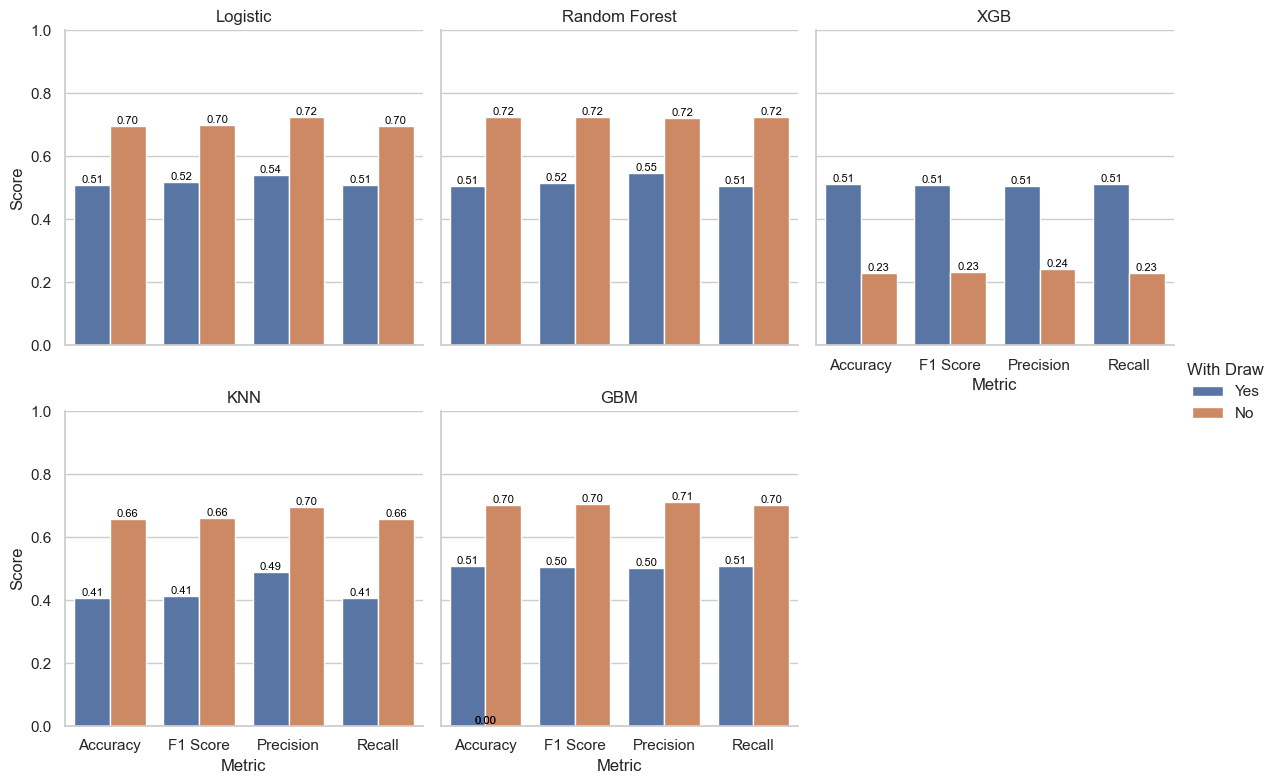

In [55]:
df_melted = df_metrics.melt(
    id_vars=['Model', 'With Draw'], 
    var_name='Metric', 
    value_name='Score'
)

g = sns.catplot(
    data=df_melted, kind="bar",
    x="Metric", y="Score", hue="With Draw",
    col="Model", col_wrap=3, height=4, ci=None
)
g.set(ylim=(0,1))
g.set_titles("{col_name}")

for ax in g.axes.flatten():
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}",  
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', va='bottom', fontsize=8, color='black'
        )

plt.show()

### Saving Best Model

In [61]:
os.makedirs("../models", exist_ok=True)
joblib.dump(random_forest_RS_nd, "../models/final_model.pkl")

['../models/final_model.pkl']

In [68]:
os.makedirs("../data/train", exist_ok=True)
os.makedirs("../data/test", exist_ok=True)

X_train_nd.to_csv("../data/train/X_train.csv", index=False)
y_train_nd.to_csv("../data/train/y_train.csv", index=False)

X_test_nd.to_csv("../data/test/X_test.csv", index=False)
y_test_nd.to_csv("../data/test/y_test.csv", index=False)


In [67]:
os.makedirs('../models', exist_ok=True)

trained_models = [
    ('LogisticRegression_NoDraw', logistic_RS_nd),
    ('LogisticRegression_Draw', logistic_RS),
    ('RandomForest_NoDraw', random_forest_RS_nd),
    ('RandomForest_Draw', random_forest_RS),
    ('XGB_NoDraw', xgb_RS_nd),
    ('XGB_Draw', xgb_RS),
    ('KNN_NoDraw', knn_RS_nd),
    ('KNN_Draw', knn_RS),
    ('GBM_NoDraw', gbm_RS_nd),
    ('GBM_Draw', gbm_RS),

    
]

# Salvar cada modelo com identificador n
for i, (name, model) in enumerate(trained_models, start=1):
    file_path = f'../models/trained_model_{i}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump(model, f)
    print(f'Saved {name} as {file_path}')

Saved LogisticRegression_NoDraw as ../models/trained_model_1.pkl
Saved LogisticRegression_Draw as ../models/trained_model_2.pkl
Saved RandomForest_NoDraw as ../models/trained_model_3.pkl
Saved RandomForest_Draw as ../models/trained_model_4.pkl
Saved XGB_NoDraw as ../models/trained_model_5.pkl
Saved XGB_Draw as ../models/trained_model_6.pkl
Saved KNN_NoDraw as ../models/trained_model_7.pkl
Saved KNN_Draw as ../models/trained_model_8.pkl
Saved GBM_NoDraw as ../models/trained_model_9.pkl
Saved GBM_Draw as ../models/trained_model_10.pkl
